<a href="https://colab.research.google.com/github/ZeyuWu2001/ZeyuWu2001.github.io/blob/Project-3/Project_3%20-%20Zeyu%20Wu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Social Science Project #3

**Enter your Name:** Zeyu Wu, Kasey Zapatka

*Semester:* Fall 2023

## 1. Introduction

### Load data

In [60]:
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# There are a few warnings that will appear that will not affect your analysis. Run this code to ignore.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Make sure to import other libraries that will be necessary for training models!

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#
# read in "Inspections Data 2011-2013" csv data
# -----------
chicago_inspections_2011_to_2013 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project3/data/Chicago Inspections 2011-2013.csv",
                                              low_memory=False)

#
# read in  "Inspections Data 2014_updated" csv data
# -----------
chicago_inspections_2014 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project3/data/Chicago Inspections 2014_updated.csv",  # be sure to use the "updated" data here
                                      low_memory=False)

In [50]:
# look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [51]:
# list column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [52]:
# drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns = ['AKA_Name',
                                                 'License',
                                                 'Address',
                                                 'City',
                                                 'State',
                                                 'Zip',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Location',
                                                 'ID',
                                                 'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                 'ACCOUNT_NUMBER',
                                                 'LEGAL_NAME',
                                                 'DOING_BUSINESS_AS_NAME',
                                                 'ADDRESS',
                                                 'CITY',
                                                 'STATE',
                                                 'ZIP_CODE',
                                                 'WARD',
                                                 'PRECINCT',
                                                 'LICENSE_CODE',
                                                 'BUSINESS_ACTIVITY_ID',
                                                 'BUSINESS_ACTIVITY',
                                                 'LICENSE_NUMBER',
                                                 'LATITUDE',
                                                 'LONGITUDE',
                                                 'pass_flag',
                                                 'fail_flag'],
                                     inplace = True)

# set index
chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [53]:
# convert the inspection date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'])

### Visualization

Let's visualize what inspections look like over time.

<Axes: title={'center': 'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

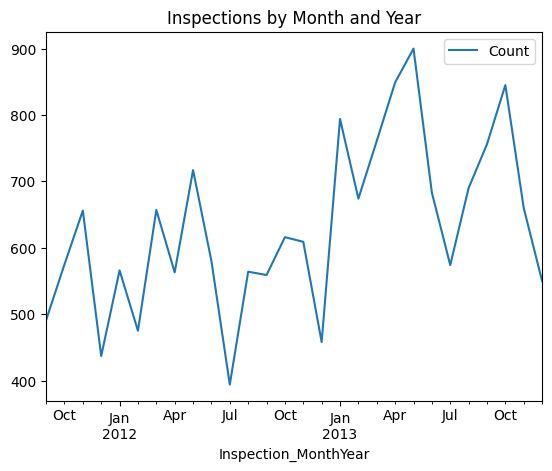

In [54]:
# visualize inspections over time
# -----------
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year")

Let's visualize what the distribution of results looks like.

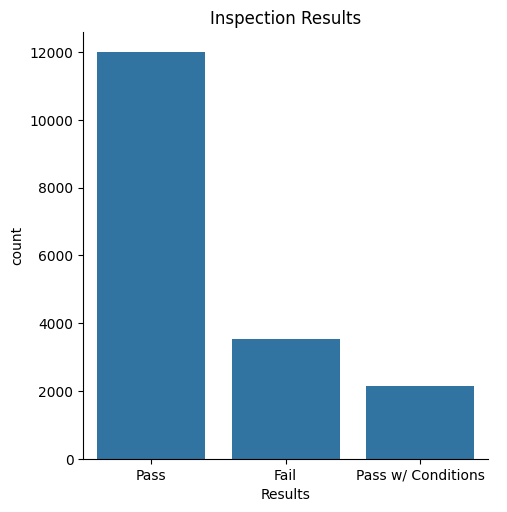

In [55]:
# view inspection results
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate results by facility type?

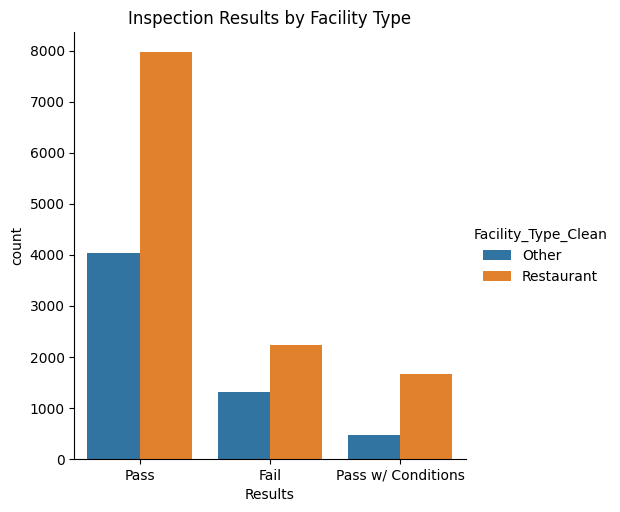

In [56]:
# view inspection results by facility type (restaurant or not)
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
            x = "Results",
            kind = "count",
            hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show();

## 2. Data Preprocessing and Cleaning

In [57]:
# drop datetime info
# -----------
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                                                                   'minDate',
                                                                                   'maxDate',
                                                                                   'Inspection_MonthYear'],
                                                                                  axis = 1)

In [58]:
# process target
# -----------
y = chicago_inspections_2011_to_2013['Results']

# decide if you want to binarize the outcome variable
# -----------
# comment out the following lines of code if you don't want to binarize the target variable
#y = y.replace({'Pass w/ Conditions': 'Pass'})
#lb_style = LabelBinarizer()
#y = lb_style.fit_transform(y)

# recode 0s and 1s so 1s are "Fail"
#y = np.where(y == 1, 0 ,1)

# No binarization; keep all three categories: 'Fail', 'Pass', 'Pass w/ Conditions'
y = y.astype('category').cat.codes  # Convert categories to numerical codes (0, 1, 2)
# Fail = 0, Pass = 1, Pass w/ Conditions = 2

# process features
# -----------

# create feature dataset
X = chicago_inspections_2011_to_2013.drop(columns = ['Results',
                                                     'Facility_Type',
                                                     'LICENSE_DESCRIPTION',
                                                     'WARD_PRECINCT'])


# get dummies
X = pd.get_dummies(X)

In [59]:
# view feature datset
X.head()

,,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,POLICE_DISTRICT,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound,Risk_Risk 1 (High),Risk_Risk 2 (Medium),Risk_Risk 3 (Low),Inspection_Type_Canvass,Facility_Type_Clean_Other,Facility_Type_Clean_Restaurant,APPLICATION_TYPE_C_EXPA,APPLICATION_TYPE_C_LOC,APPLICATION_TYPE_ISSUE,APPLICATION_TYPE_RENEW
Inspection_ID,DBA_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269961,SEVEN STAR,0,0,2,0,0,0,0,2.0,1,19.0,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0,False,False,True,True,True,False,False,False,False,True
507211,PANERA BREAD,0,0,3,0,0,0,0,2.0,1,24.0,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0,True,False,False,True,False,True,False,False,False,True
507212,LITTLE QUIAPO RESTAURANT,0,2,6,0,0,0,0,2.0,1,17.0,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0,True,False,False,True,False,True,False,False,False,True
507216,SERGIO'S TAQUERIA PIZZA INC.,0,0,6,0,0,0,0,2.0,1,17.0,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0,True,False,False,True,False,True,False,False,False,True
507219,TARGET STORE # T-2079,0,2,6,0,0,0,0,2.0,1,24.0,5.290411,0,0,1,0,0,1,0,0,0,0,0,0,0.009987,52.730000,16.266667,0.690000,9.530785,3.401567,2.126788,0,False,True,False,True,False,True,False,False,False,True


## 3. Fit Models

Now choose 3 different machine learning techniques and apply them below. Choose from one of the algorithms we have used in lab (e.g., logistic regression, random forests, `AdaBoost()`, `xgboost()`, `VotingClassifer()`, or `BART`).

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem. Also, be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using either train/validation splits or cross-validation)

### Model 1

In [ ]:
# Define XGBoost model
xgb = XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Hyperparameter tuning
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X, y)

# Print the best parameters and accuracy
print("Model 1: XGBoost")
print("Best Parameters:", grid_xgb.best_params_)
print("Cross-validated Accuracy:", grid_xgb.best_score_)

Model 1: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Cross-validated Accuracy: 0.9252176319924732


###  Model 2

In [ ]:
# Define Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameter tuning
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)

# Print the best parameters and accuracy
print("Model 2: Random Forest")
print("Best Parameters:", grid_rf.best_params_)
print("Cross-validated Accuracy:", grid_rf.best_score_)

Model 2: Random Forest
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Cross-validated Accuracy: 0.9226705545401563


### Model 3

In [61]:
# Define VotingClassifier with XGBoost, Random Forest, and Logistic Regression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('xgb', grid_xgb.best_estimator_),
    ('rf', grid_rf.best_estimator_)
], voting='soft')

# Fit the VotingClassifier
voting_clf.fit(X, y)

# Print cross-validated accuracy for VotingClassifier
from sklearn.model_selection import cross_val_score
voting_scores = cross_val_score(voting_clf, X, y, cv=5, scoring='accuracy')
print("\nModel 3: VotingClassifier")
print("Cross-validated Accuracy:", voting_scores.mean())


Model 3: VotingClassifier
Cross-validated Accuracy: 0.9234542067059847


### Validation Metrics

Be sure to explain which of these metrics you would want to prioritize when conducting predictive auditing in this context and why.

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

In [62]:
# Define scoring metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Evaluate all models
models = {
    'XGBoost': grid_xgb.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'Voting Classifier': voting_clf
}

results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    results[model_name] = {}
    for metric_name, scorer in scorers.items():
        score = cross_val_score(model, X, y, cv=5, scoring=scorer).mean()
        results[model_name][metric_name] = score
        print(f"{metric_name.capitalize()}: {score:.4f}")


Evaluating XGBoost...
Accuracy: 0.9252
Precision: 0.9286
Recall: 0.9252
F1: 0.9216

Evaluating Random Forest...
Accuracy: 0.9227
Precision: 0.9276
Recall: 0.9227
F1: 0.9179

Evaluating Voting Classifier...
Accuracy: 0.9235
Precision: 0.9276
Recall: 0.9235
F1: 0.9190


## 4. Policy Simulation

### Interpretable Machine Learning

Use tools like coefficient plots or feature importance plots to investigate your models. Which features contribute to your predictions? Are there any additional features you wish you could incorporate that you don't have available in this analysis?

**Hint**: Use tools like feature importance plots and coefficient plots.

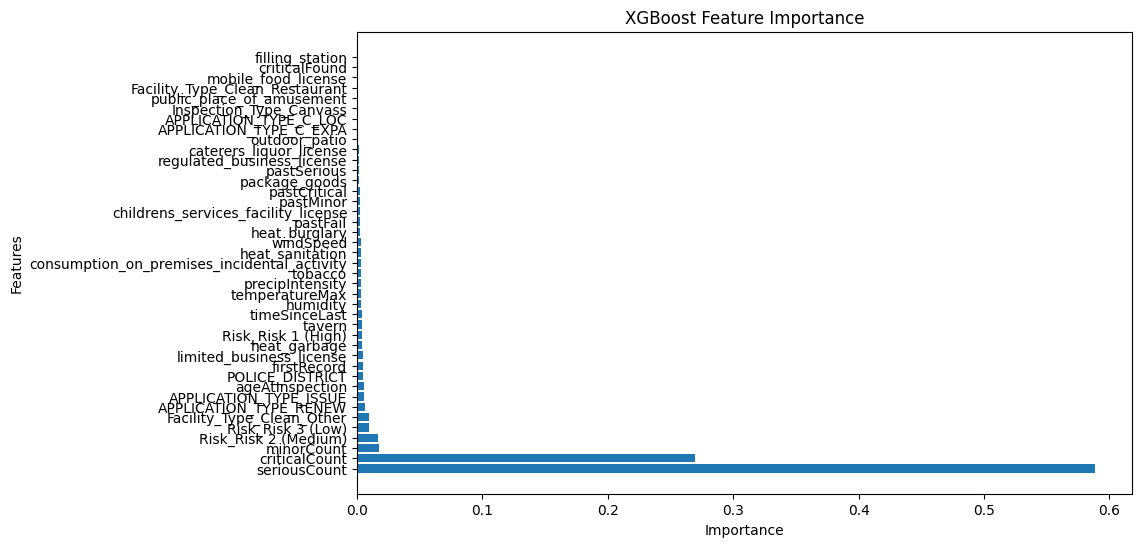

In [ ]:
# XGBoost Feature Importance
xgb_feature_importance = grid_xgb.best_estimator_.feature_importances_
xgb_features = X.columns
xgb_sorted_indices = np.argsort(xgb_feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(np.array(xgb_features)[xgb_sorted_indices], xgb_feature_importance[xgb_sorted_indices])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

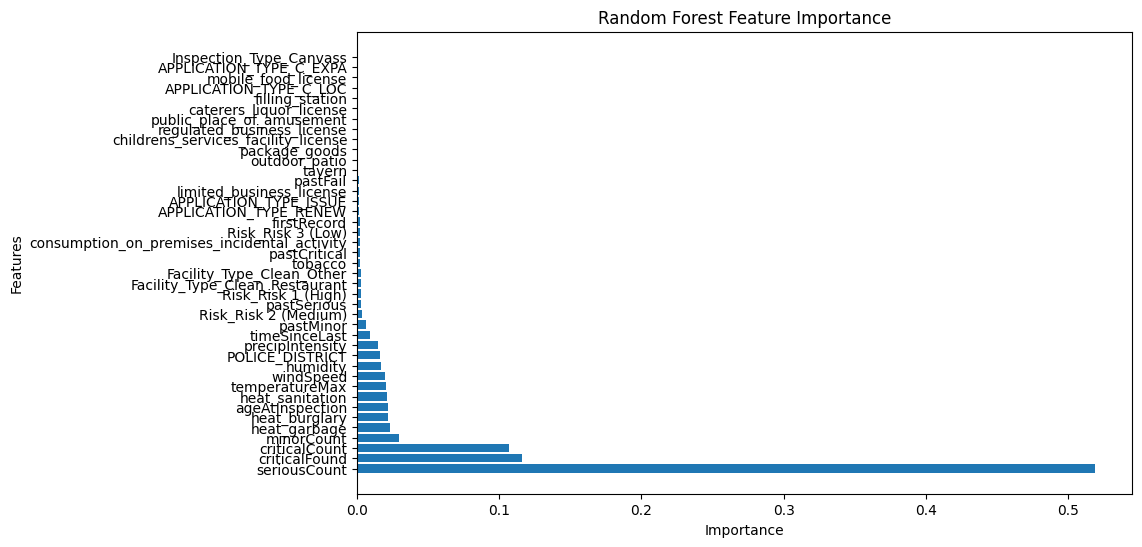

In [ ]:
# Random Forest Feature Importance
rf_feature_importance = grid_rf.best_estimator_.feature_importances_
rf_sorted_indices = np.argsort(rf_feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(np.array(xgb_features)[rf_sorted_indices], rf_feature_importance[rf_sorted_indices])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

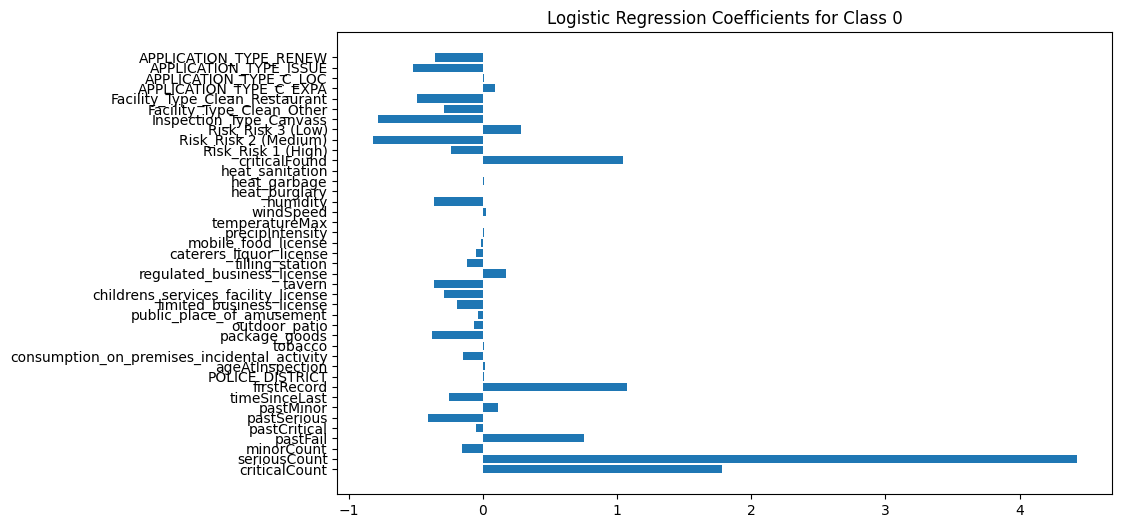

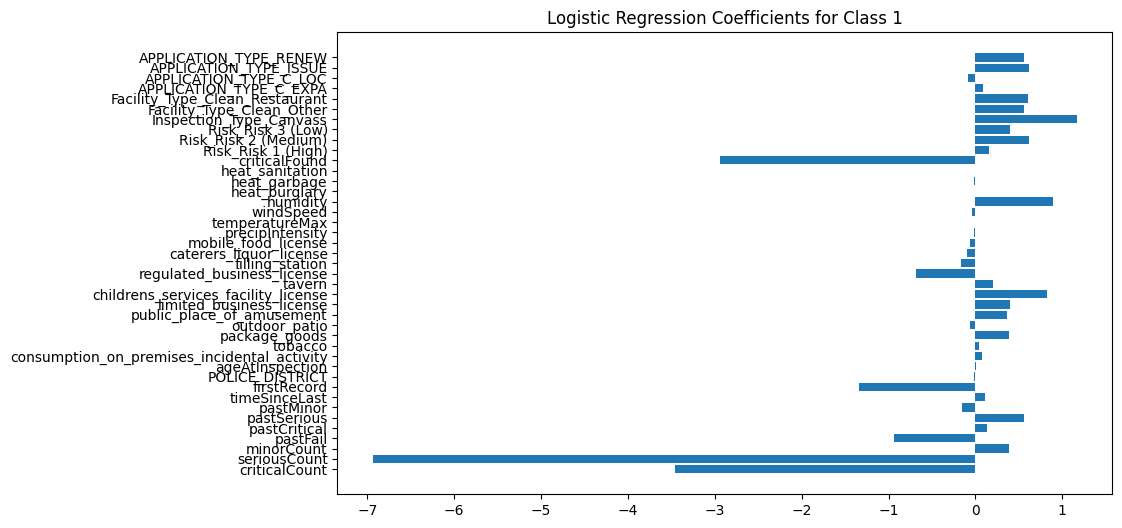

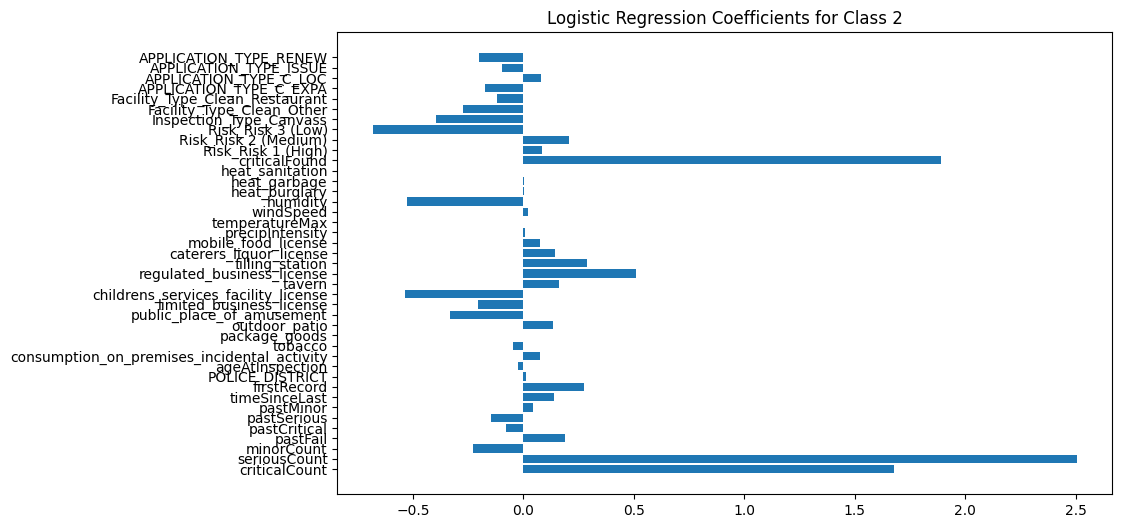

In [ ]:
#Logistic Regression Coefficients (from Voting Classifier)
logreg = voting_clf.named_estimators_['logreg']
coefficients = logreg.coef_
feature_names = X.columns

for i, class_label in enumerate(logreg.classes_):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients[i])
    plt.title(f"Logistic Regression Coefficients for Class {class_label}")
    plt.show()

### Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then:
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities.
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random

In [ ]:
# 1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities.

# Predict probabilities and outcomes using the VotingClassifier
y_pred = voting_clf.predict(X)
y_prob = voting_clf.predict_proba(X)

# Create a DataFrame to store predictions and probabilities
audit_data = pd.DataFrame(y_prob, columns=['Fail', 'Pass', 'Pass w/ Conditions'])
audit_data['Predicted_Class'] = y_pred
audit_data['Fail_Probability'] = audit_data['Fail']  # Assuming "Fail" is class 0
audit_data['Actual_Class'] = y.reset_index(drop=True)  # Align Actual_Class with the audit_data index

In [ ]:
# 2. Order your audits by their probability of detecting a "Fail" score

# Sort data by the probability of detecting "Fail"
ordered_audits = audit_data.sort_values('Fail_Probability', ascending=False)

# Select the top 1,000 observations
top_1000_audits = ordered_audits.head(1000)

# Display the top 5 establishments for audit prioritization
print("Top 5 establishments to prioritize for audits:")
print(top_1000_audits.head())

Top 5 establishments to prioritize for audits:
           Fail      Pass  Pass w/ Conditions  Predicted_Class  \
13279  0.979896  0.001344            0.018761                0   
13303  0.978878  0.005350            0.015772                0   
14236  0.977862  0.005816            0.016323                0   
8892   0.976420  0.001318            0.022262                0   
10226  0.976242  0.002212            0.021546                0   

       Fail_Probability  Actual_Class  
13279          0.979896             0  
13303          0.978878             0  
14236          0.977862             0  
8892           0.976420             0  
10226          0.976242             0  


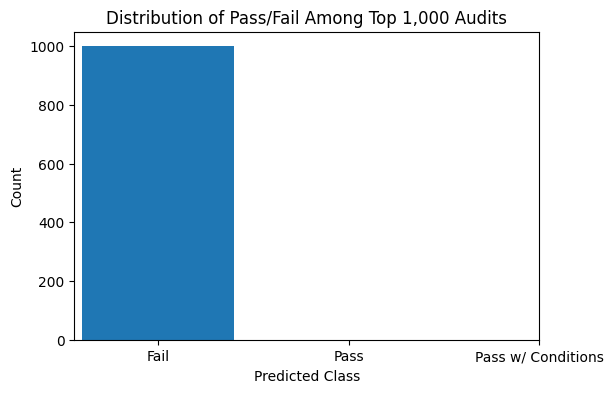

In [ ]:
# 3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset

# Count distribution of predicted classes in the top 1,000 audits
top_1000_distribution = top_1000_audits['Predicted_Class'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(top_1000_distribution.index, top_1000_distribution.values)
plt.title("Distribution of Pass/Fail Among Top 1,000 Audits")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1, 2], labels=['Fail', 'Pass', 'Pass w/ Conditions'])
plt.show()

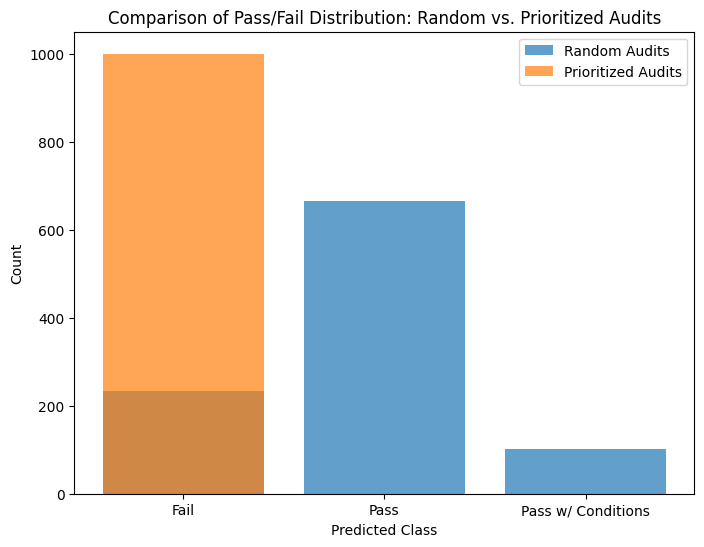

In [ ]:
# 4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random

# Randomly sample 1,000 observations
random_audits = audit_data.sample(1000)

# Count the distribution of predicted classes in random audits
random_distribution = random_audits['Predicted_Class'].value_counts()

# Plot comparison of random vs. prioritized audits
plt.figure(figsize=(8, 6))
plt.bar(random_distribution.index, random_distribution.values, alpha=0.7, label="Random Audits")
plt.bar(top_1000_distribution.index, top_1000_distribution.values, alpha=0.7, label="Prioritized Audits")
plt.title("Comparison of Pass/Fail Distribution: Random vs. Prioritized Audits")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1, 2], labels=['Fail', 'Pass', 'Pass w/ Conditions'])
plt.legend()
plt.show()

### Predict on 2014 inspection data

Use your favorite model to make predictions based on the features using the "Chicago Inspection 2014_updated.csv" file. Treat this as you would a test dataset. This means you will have to format the features (including removing some features and getting dummies) and the label (binarize and recode) in the same way you did the training data. (Remember the "Results" column is your label). You will then compare your predictions with the actual.

In [ ]:
# data processing

# process features
# Drop unnecessary columns in the 2014 dataset
X_test2014 = chicago_inspections_2014.drop(columns=['Results', 'Facility_Type', 'LICENSE_DESCRIPTION', 'WARD_PRECINCT'])

# Get dummies for categorical columns
X_test2014 = pd.get_dummies(X_test2014)

# Align columns with training data (fill missing columns with 0)
X_test2014 = X_test2014.reindex(columns=X.columns, fill_value=0)

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_test2014 = pd.DataFrame(imputer.fit_transform(X_test2014), columns=X_test2014.columns)

# process target
y_test2014 = chicago_inspections_2014['Results'].astype('category').cat.codes

In [ ]:
# predict and compare
# Predict using the VotingClassifier
y_pred2014 = voting_clf.predict(X_test2014)

In [ ]:
# evaluate

# Generate a classification report
print("2014 Data Classification Report:")
print(classification_report(y_test2014, y_pred2014))

# Calculate and print accuracy
accuracy = accuracy_score(y_test2014, y_pred2014)
print(f"Accuracy on 2014 data: {accuracy:.4f}")

2014 Data Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       899
           1       1.00      1.00      1.00      3012
           2       0.79      0.55      0.65       712

    accuracy                           0.91      4623
   macro avg       0.84      0.81      0.81      4623
weighted avg       0.91      0.91      0.90      4623

Accuracy on 2014 data: 0.9079


## 5. Discussion Questions

1. Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?


**A1**

Accuracy alone doesn’t tell the full story. In fields like public policy, the data is often imbalanced, with some outcomes (e.g., restaurant failures) being rare compared to others (e.g., passing inspections). A model could achieve high accuracy simply by predicting the majority class all the time, but that wouldn’t be helpful for identifying critical cases like health violations.

Metrics like **precision** and **recall** are essential because they address different priorities. For instance:
- **Precision** ensures that when we predict a failure, it’s likely to be correct. This is important for efficiently allocating limited resources, such as targeting audits where they’re most needed.
- **Recall** ensures we’re catching as many failures as possible, minimizing the risk of overlooking establishments that pose a public health threat.

The **F1-score** balances these two, which can be useful when there’s a trade-off between precision and recall. In short, beyond accuracy, these metrics help ensure the model aligns with the real-world goals of fairness, efficiency, and public safety.

2. Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decisionmaking and real world behavior?

**A2**

If establishments learn how the algorithm works, they might game the system by focusing only on the features the model considers important while neglecting other aspects of compliance. To address this:

1. **Regularly Update the Algorithm**:
   Algorithms should be updated frequently with new data to capture evolving patterns of non-compliance. This reduces the chance of establishments gaming a static system.

2. **Introduce Randomized Audits**:
   Incorporating an element of randomness ensures that even establishments that appear compliant based on the model’s predictions can still be audited. This creates uncertainty, discouraging gaming behavior.

3. **Broaden Data Collection**:
   Policymakers should consider additional features beyond the most obvious ones (e.g., past violations). This might include indirect indicators like customer complaints or proximity to known high-risk areas, making it harder for establishments to predict and manipulate outcomes.

4. **Use Adaptive Thresholds**:
   Rather than setting fixed thresholds for failures, adaptive thresholds based on broader trends (e.g., seasonal patterns or regional differences) can make it harder for establishments to game the system.

5. **Behavioral Nudges**:
   Instead of purely relying on penalties, offer incentives for establishments to exceed baseline standards, encouraging good practices rather than just avoiding bad ones.

6. **Transparency with Limits**:
   While some transparency about the goals of the audits is necessary, revealing the exact algorithmic features and weights should be avoided to reduce the risk of gaming.

By combining these strategies, policymakers can create a system that remains effective, even as establishments adapt to the rules. It’s a constant interplay, but with proactive measures, the system can maintain fairness and accountability.